In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np


In [ ]:
def draw_weights(weights):
    #if fig is None:
    fig = plt.figure(figsize=(12.9,10))
    pxl_x = 30
    pxl_y = 30
    n_units, _ = weights.shape

    all_weights = np.zeros((pxl_y*n_units,pxl_x))
    print(all_weights.shape)

    # iterate over units
    for unit in range(n_units):
        all_weights[unit*pxl_y:(unit+1)*pxl_y, :] = weights[unit,:].reshape(pxl_y,pxl_x)

    abs_max = np.amax(np.absolute(all_weights))
    im = plt.imshow(all_weights, cmap='bwr', vmin=-abs_max, vmax=abs_max)
    fig.colorbar(im, ticks=[np.amin(all_weights), 0, np.amax(all_weights)])
    plt.axis('off')
    plt.title(f"Weights at epoch: {epoch}")

    fig.canvas.draw()   
    display(fig)
    clear_output(wait=True)
    fig.clear()
    plt.close(fig)

In [ ]:
class BCM_Model(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        self.weights = torch.normal( mean=0, std=1, size=(n_units, n_in),dtype=torch.float64)
        self.threshold = torch.zeros(n_units)
        self.threshold_view = torch.reshape(self.threshold, (n_units,1)).expand(-1, batch_size) 
        self.act = lambda y: y *(y - self.threshold_view)
        self.activations = []

    def forward(self, x):
        y = self.act(torch.mm(self.weights, x))
        return y
    
    def update(self, x, dt=1):
        # update threshold
        y = torch.mm(self.weights, x)
        self.threshold = torch.mean(y, dim=1)

        # update weights
        act = self.act(y)
        delta_w = (torch.mm(act,x.T) - eps * self.weights)* dt
        self.weights += delta_w

        # for visu
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([10, 5])
(300, 30)


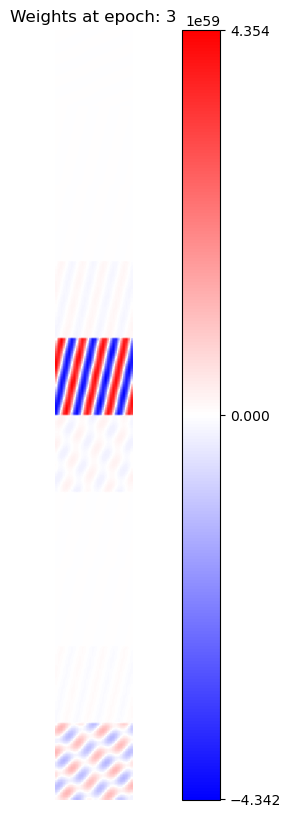

In [21]:


# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# hps
n_epochs = 4
learning_rate = 1
n_units = 10
batch_size = 5
eps = 1

model = BCM_Model(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch)
        draw_weights(model.weights)


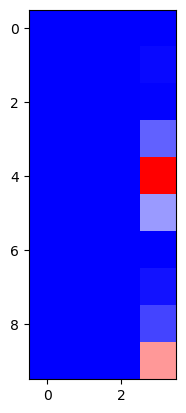

In [25]:
y = np.array(model.activations)
plt.imshow(y.T,cmap='bwr')